In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import time
import os
from sklearn.metrics import silhouette_score
import umap
import seaborn as sns

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

folder_path = r"C:\Users\tere1\OneDrive\Escritorio\TFM\datos_img"
# Cargar las características normalizadas por Z-score
df_color_z = pd.read_csv(os.path.join(folder_path, "features_color_all_zscore.csv"))
# Cargar las características normalizadas por Min-Max
df_color_mm = pd.read_csv(os.path.join(folder_path, "features_color_all_minmax.csv"))


In [4]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_color_z_cl= df_color_z.drop(columns=['filename', 'label'])

In [5]:
def _get_init_centers(n_clusters, n_samples):
    '''Return random unique indices as initial medoid centers'''
    return np.random.choice(n_samples, size=n_clusters, replace=False).tolist()

def _get_distance(data1, data2):
    '''Euclidean distance function'''
    return np.sqrt(np.sum((data1 - data2) ** 2))

def _get_cost(X, centers_id, dist_func):
    '''Return members, per-cluster costs, total cost, and distance matrix'''
    dist_mat = np.zeros((len(X), len(centers_id)))
    for j, center_id in enumerate(centers_id):
        center = X[center_id, :]
        for i in range(len(X)):
            if i == center_id:
                dist_mat[i, j] = 0.
            else:
                dist_mat[i, j] = dist_func(X[i, :], center)

    mask = np.argmin(dist_mat, axis=1)
    members = mask.copy()
    costs = np.array([np.sum(dist_mat[mask == i, i]) for i in range(len(centers_id))])
    return members, costs, np.sum(costs), dist_mat

def _kmedoids_run(X, n_clusters, dist_func, max_iter=1000, tol=0.001, verbose=True):
    n_samples = X.shape[0]
    centers = _get_init_centers(n_clusters, n_samples)
    if verbose:
        print("Initial centers are", centers)

    members, costs, tot_cost, dist_mat = _get_cost(X, centers, dist_func)
    cc, swapped = 0, True

    while swapped and cc < max_iter:
        swapped = False
        for i in range(n_samples):
            if i not in centers:
                for j in range(len(centers)):
                    new_centers = deepcopy(centers)
                    new_centers[j] = i
                    members_, costs_, tot_cost_, dist_mat_ = _get_cost(X, new_centers, dist_func)
                    if tot_cost - tot_cost_ > tol:
                        members, costs, tot_cost, dist_mat = members_, costs_, tot_cost_, dist_mat_
                        centers = new_centers
                        swapped = True
                        if verbose:
                            print("Change centers to", centers)
        cc += 1

    if verbose:
        if not swapped:
            print("End Searching by no swaps")
        else:
            print("End Searching by reaching maximum iteration", max_iter)

    return centers, members, costs, tot_cost, dist_mat, cc

class KMedoids:
    '''
    K-Medoids Clustering (PAM) Algorithm

    Parameters
    ----------
    n_clusters : int
        Number of clusters
    dist_func : callable
        Distance function (default: Euclidean)
    max_iter : int
        Maximum number of iterations
    tol : float
        Tolerance to stop swapping
    '''
    def __init__(self, n_clusters, dist_func=_get_distance, max_iter=1000, tol=0.001):
        self.n_clusters = n_clusters
        self.dist_func = dist_func
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X, plotit=True, verbose=True):
        self.X_train = X
        result = _kmedoids_run(
            X, self.n_clusters, self.dist_func, self.max_iter, self.tol, verbose
        )
        self.centers_, self.labels_, self.costs_, self.total_cost_, self.dist_mat_, self.n_iter_ = result

        if plotit and X.shape[1] == 2:
            self._plot_clusters(X)
        elif plotit:
            print("Plotting only supported for 2D data.")

    def predict(self, X):
        if not hasattr(self, "centers_"):
            raise RuntimeError("Model has not been fitted.")
        labels = np.zeros(len(X), dtype=int)
        for i, x in enumerate(X):
            dists = [self.dist_func(x, self.X_train[c]) for c in self.centers_]
            labels[i] = np.argmin(dists)
        return labels

    def _plot_clusters(self, X):
        plt.figure(figsize=(8, 6))
        cmap = plt.get_cmap('tab10')
        for i in range(self.n_clusters):
            cluster_points = X[self.labels_ == i]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                        color=cmap(i), alpha=0.5, label=f'Cluster {i}')
            plt.scatter(X[self.centers_[i], 0], X[self.centers_[i], 1],
                        color=cmap(i), marker='*', s=300, edgecolor='k')
        plt.title("K-Medoids Clustering")
        plt.legend()
        plt.grid(True)
        plt.show()

In [6]:
# Convertir el DataFrame a un arreglo NumPy (asegúrate de que solo contiene variables numéricas)
X = df_color_z_cl.values  

# Crear modelo con el número de clusters que estimes apropiado
model = KMedoids(n_clusters=4)  

# Ajustar el modelo
model.fit(X, plotit=False)  # Desactiva plotit si los datos no son 2D

# Ver resultados
print("Medoides:", model.centers_)
print("Etiquetas:", model.labels_)

Initial centers are [385, 354, 232, 391]
Change centers to [385, 1, 232, 391]
Change centers to [2, 1, 232, 391]
Change centers to [2, 1, 232, 3]
Change centers to [2, 1, 5, 3]
Change centers to [2, 1, 6, 3]
Change centers to [9, 1, 6, 3]
Change centers to [9, 1, 11, 3]
Change centers to [9, 13, 11, 3]
Change centers to [9, 13, 11, 14]
Change centers to [18, 13, 11, 14]
Change centers to [18, 22, 11, 14]
Change centers to [33, 22, 11, 14]
Change centers to [33, 22, 34, 14]
Change centers to [33, 22, 34, 37]
Change centers to [33, 22, 41, 37]
Change centers to [33, 22, 41, 62]
Change centers to [33, 83, 41, 62]
Change centers to [118, 83, 41, 62]
Change centers to [118, 83, 41, 142]
Change centers to [118, 83, 171, 142]
Change centers to [118, 83, 172, 142]
Change centers to [287, 83, 172, 142]
Change centers to [295, 83, 172, 142]
End Searching by no swaps
Medoides: [295, 83, 172, 142]
Etiquetas: [2 1 3 3 3 2 2 2 3 0 2 2 2 3 3 2 2 2 0 2 2 0 1 0 2 2 3 0 3 1 2 3 0 0 2 3 3
 3 3 3 0 2 0 3 

In [7]:
score = silhouette_score(X, model.labels_)
print(f"Coeficiente de silueta: {score:.4f}")


Coeficiente de silueta: 0.3421


In [8]:
y_true = df_color_z['label'].values
y_pred = model.labels_
tabla_contingencia = pd.crosstab(y_true, y_pred, rownames=['Etiqueta real'], colnames=['Cluster K-Medoids'])
print(tabla_contingencia)


Cluster K-Medoids   0   1   2   3
Etiqueta real                    
higher             90  25  60  93
smaller            68  56  65  80


In [9]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_color_mm_cl= df_color_mm.drop(columns=['filename', 'label'])

In [10]:
# Convertir el DataFrame a un arreglo NumPy (asegúrate de que solo contiene variables numéricas)
X = df_color_mm_cl.values  

# Crear modelo con el número de clusters que estimes apropiado
model = KMedoids(n_clusters=4)  

# Ajustar el modelo
model.fit(X, plotit=False)  # Desactiva plotit si los datos no son 2D

# Ver resultados
print("Medoides:", model.centers_)
print("Etiquetas:", model.labels_)

Initial centers are [517, 49, 492, 27]
Change centers to [517, 1, 492, 27]
Change centers to [517, 2, 492, 27]
Change centers to [13, 2, 492, 27]
Change centers to [13, 2, 16, 27]
Change centers to [13, 2, 16, 18]
Change centers to [13, 2, 20, 18]
Change centers to [13, 26, 20, 18]
Change centers to [13, 26, 20, 33]
Change centers to [13, 26, 34, 33]
Change centers to [13, 35, 34, 33]
Change centers to [54, 35, 34, 33]
Change centers to [55, 35, 34, 33]
Change centers to [59, 35, 34, 33]
Change centers to [59, 62, 34, 33]
Change centers to [83, 62, 34, 33]
Change centers to [83, 62, 34, 86]
Change centers to [83, 62, 34, 118]
Change centers to [83, 142, 34, 118]
Change centers to [83, 142, 172, 118]
Change centers to [83, 142, 172, 287]
Change centers to [83, 142, 172, 295]
End Searching by no swaps
Medoides: [83, 142, 172, 295]
Etiquetas: [2 0 1 1 1 2 2 2 1 3 2 2 2 1 1 2 2 2 3 2 2 3 0 3 2 2 1 3 1 0 2 1 3 3 2 1 1
 1 1 1 3 2 3 1 3 2 2 3 2 2 1 1 1 1 1 0 3 2 1 0 1 1 1 1 1 0 1 3 0 0 0 3 2 

In [11]:
score = silhouette_score(X, model.labels_)
print(f"Coeficiente de silueta: {score:.4f}")

Coeficiente de silueta: 0.3460


In [12]:
y_true = df_color_mm['label'].values
y_pred = model.labels_
tabla_contingencia = pd.crosstab(y_true, y_pred, rownames=['Etiqueta real'], colnames=['Cluster K-Medoids'])
print(tabla_contingencia)

Cluster K-Medoids   0   1   2   3
Etiqueta real                    
higher             25  93  60  90
smaller            55  82  64  68


reducir ladimensionaliad con umap

In [13]:
# Reducir dimensionalidad 
umap_model_z = umap.UMAP(n_neighbors= 8, n_components=2, random_state=42) #7
umap_zscore = umap_model_z.fit_transform(df_color_z_cl)

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Initial centers are [412, 46, 319, 251]
Change centers to [1, 46, 319, 251]
Change centers to [1, 3, 319, 251]
Change centers to [1, 3, 4, 251]
Change centers to [1, 3, 5, 251]
Change centers to [1, 3, 6, 251]
Change centers to [13, 3, 6, 251]
Change centers to [13, 14, 6, 251]
Change centers to [13, 14, 6, 18]
Change centers to [13, 24, 6, 18]
Change centers to [13, 26, 6, 18]
Change centers to [29, 26, 6, 18]
Change centers to [29, 38, 6, 18]
Change centers to [29, 39, 6, 18]
Change centers to [29, 53, 6, 18]
Change centers to [54, 53, 6, 18]
Change centers to [54, 53, 77, 18]
Change centers to [54, 53, 77, 111]
Change centers to [54, 53, 77, 118]
Change centers to [54, 53, 176, 118]
Change centers to [54, 53, 176, 277]
Change centers to [460, 53, 176, 277]
End Searching by no swaps


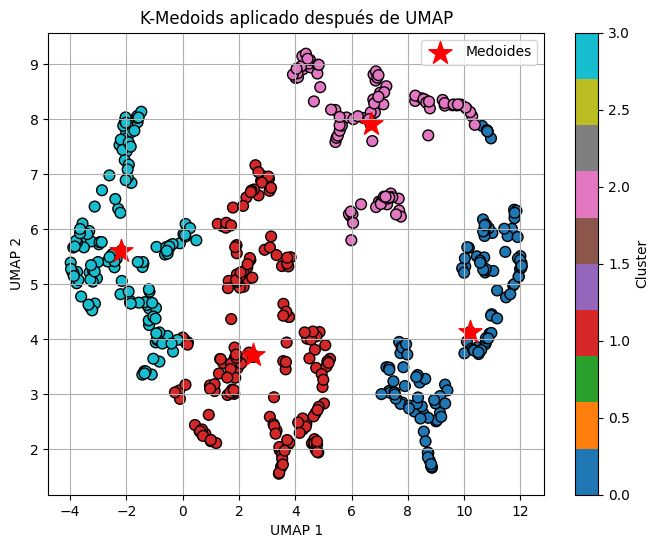

In [14]:
#aplicar kmedoids al dataset reducido
model_umap_zscore = KMedoids(n_clusters=4)  
model_umap_zscore.fit(umap_zscore, plotit=False)


# Visualizar resultados
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    umap_zscore[:, 0], umap_zscore[:, 1],
    c=model_umap_zscore.labels_, cmap='tab10', s=60, edgecolor='k'
)
plt.scatter(
    [umap_zscore[i, 0] for i in model_umap_zscore.centers_],
    [umap_zscore[i, 1] for i in model_umap_zscore.centers_],
    marker='*', c='red', s=300, label='Medoides'
)
plt.title("K-Medoids aplicado después de UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, label="Cluster")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
score = silhouette_score(umap_zscore, model_umap_zscore.labels_)
print(f"Silhouette Score (UMAP + K-Medoids): {score:.3f}")


Silhouette Score (UMAP + K-Medoids): 0.495


In [16]:
y_true = df_color_z['label'].values
y_pred = model_umap_zscore.labels_

tabla_z_umap = pd.crosstab(y_true, y_pred, rownames=['Etiqueta real'], colnames=['Cluster'])
print(tabla_z_umap)

Cluster         0   1   2   3
Etiqueta real                
higher         55  81  48  84
smaller        78  90  52  49


con min-max

In [17]:
# Reducir dimensionalidad 
umap_model_mm = umap.UMAP(n_neighbors= 7, n_components=2, random_state=42) #7
umap_mm = umap_model_mm.fit_transform(df_color_mm_cl)

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Initial centers are [365, 245, 54, 514]
Change centers to [365, 245, 54, 6]
Change centers to [365, 245, 54, 7]
Change centers to [9, 245, 54, 7]
Change centers to [9, 245, 54, 11]
Change centers to [9, 245, 13, 11]
Change centers to [18, 245, 13, 11]
Change centers to [21, 245, 13, 11]
Change centers to [21, 245, 22, 11]
Change centers to [21, 24, 22, 11]
Change centers to [21, 26, 22, 11]
Change centers to [21, 26, 29, 11]
Change centers to [21, 53, 29, 11]
Change centers to [21, 53, 29, 77]
Change centers to [21, 53, 93, 77]
Change centers to [21, 101, 93, 77]
Change centers to [118, 101, 93, 77]
Change centers to [118, 101, 196, 77]
Change centers to [118, 247, 196, 77]
Change centers to [118, 252, 196, 77]
Change centers to [118, 252, 427, 77]
End Searching by no swaps
Cluster         0   1   2   3
Etiqueta real                
higher         79  86  55  48
smaller        46  93  72  58


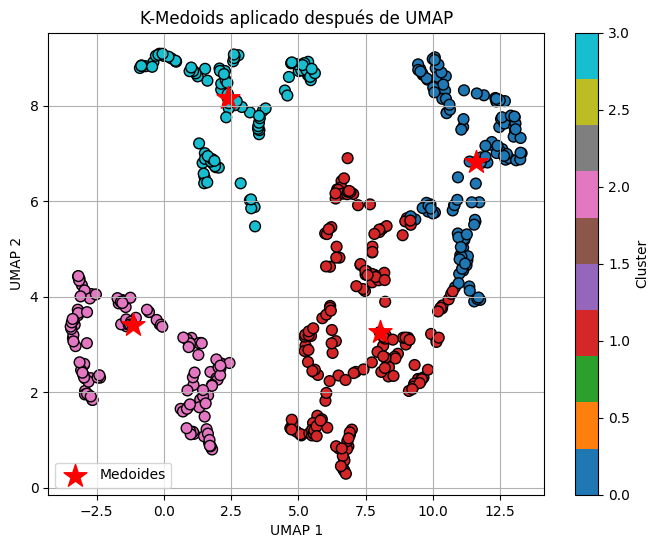

In [18]:
#aplicar kmedoids al dataset reducido
model_umap_mm = KMedoids(n_clusters=4)  
model_umap_mm.fit(umap_mm, plotit=False)

cluster_labels = model_umap_mm.labels_
 
# Crear la tabla de contingencia
contingencia = pd.crosstab(y_true, cluster_labels, rownames=['Etiqueta real'], colnames=['Cluster'])
print(contingencia)

# Visualizar resultados
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    umap_mm[:, 0], umap_mm[:, 1],
    c=model_umap_mm.labels_, cmap='tab10', s=60, edgecolor='k'
)
plt.scatter(
    [umap_mm[i, 0] for i in model_umap_mm.centers_],
    [umap_mm[i, 1] for i in model_umap_mm.centers_],
    marker='*', c='red', s=300, label='Medoides'
)
plt.title("K-Medoids aplicado después de UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, label="Cluster")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
score = silhouette_score(umap_mm, model_umap_mm.labels_)
print(f"Silhouette Score (UMAP + K-Medoids): {score:.3f}")

Silhouette Score (UMAP + K-Medoids): 0.533


In [20]:
y_true = df_color_mm['label'].values
y_pred = model_umap_mm.labels_

tabla_mm_umap = pd.crosstab(y_true, y_pred, rownames=['Etiqueta real'], colnames=['Cluster'])
print(tabla_mm_umap)

Cluster         0   1   2   3
Etiqueta real                
higher         79  86  55  48
smaller        46  93  72  58


Se obtienen 4 clusteres muy equilibrados en número de imágenes smaller y higher. Puede que el color no permita separar clramente las dos clses. Por tanto, el color no sería un buen predictor de callos grandes y pequeños. Habrá cuatro agrupaciones distintas en los datos basadas en las características de color independientes de higher y smaller.

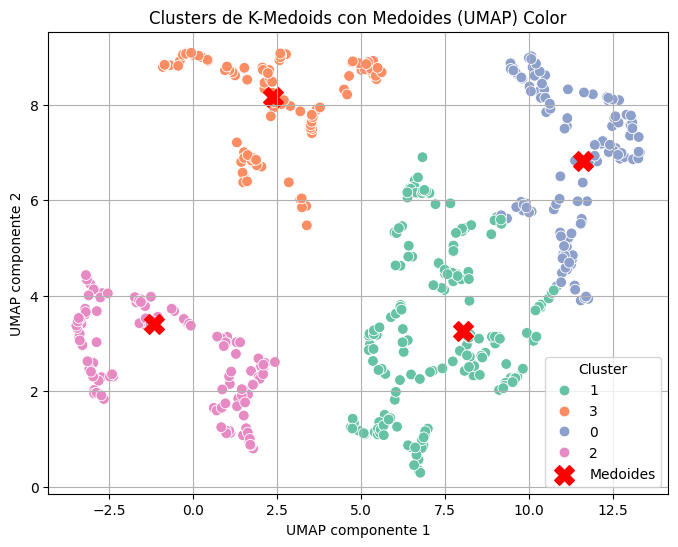

In [25]:
# Obtener etiquetas y medoids correctamente
cluster_labels = model_umap_mm.labels_
medoids_2D_mm = umap_mm[model_umap_mm.centers_]


# Crear DataFrame para visualización
df_plot = pd.DataFrame({
    'UMAP 1': umap_mm[:, 0],
    'UMAP 2': umap_mm[:, 1],
    'Cluster': cluster_labels.astype(str)
})

# DataFrame para los medoides
medoids_df = pd.DataFrame({
    'UMAP 1': medoids_2D_mm[:, 0],
    'UMAP 2': medoids_2D_mm[:, 1],
    'Cluster': ['Medoid'] * len(medoids_2D_mm)
})

# Paleta para clusters
palette = sns.color_palette('Set2', n_colors=len(df_plot['Cluster'].unique()))

plt.figure(figsize=(8, 6))

# Scatterplot para clusters
sns.scatterplot(
    data=df_plot,
    x='UMAP 1',
    y='UMAP 2',
    hue='Cluster',
    palette=palette,
    s=60,
    edgecolor='white',
    alpha=1,
    legend='full'
)

# Graficar medoides
plt.scatter(
    medoids_df['UMAP 1'],
    medoids_df['UMAP 2'],
    c='red',
    marker='X',
    s=200,
    label='Medoides'
)

plt.title("Clusters de K-Medoids con Medoides (UMAP) Color")
plt.xlabel("UMAP componente 1")
plt.ylabel("UMAP componente 2")
plt.grid(True)
plt.legend(title='Cluster')
plt.show()
